Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

C:\Users\fabio\Anaconda3\envs\tflw\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = r'Z:\Staff\Fabio_Disidoro\Hip_hop\Programming\MachineLearning\Udacity_Course\notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic regression with mini-batch SGD and L2 regularization

In [7]:
# Logistic regression model
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  # Also the regularization hyperparameter will be chosen at run time.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_regularisation_beta = tf.placeholder(tf.float32)
    
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)) + \
        tf_regularisation_beta*tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    

Study of different values of the regularization hyperparameter

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


Text(0,0.5,'test accuracy')

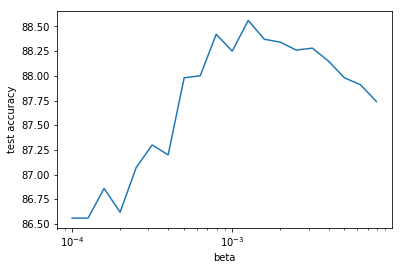

In [14]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []

# Run for different values of the regularization hyperparameter and plot test accuracy only
for beta in regul_val: 
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_regularisation_beta: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))
    
plt.semilogx(regul_val, accuracy_vals)          
plt.xlabel('beta')
plt.ylabel('test accuracy')

Choice of best hyperparameter for regularization: 1e-3

In [15]:
num_steps = 3001
beta = 1e-3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_regularisation_beta: beta}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 23.513958
Minibatch accuracy: 10.2%
Validation accuracy: 13.1%
Minibatch loss at step 500: 2.675632
Minibatch accuracy: 76.6%
Validation accuracy: 76.2%
Minibatch loss at step 1000: 1.893313
Minibatch accuracy: 76.6%
Validation accuracy: 78.1%
Minibatch loss at step 1500: 1.209241
Minibatch accuracy: 85.2%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 0.736511
Minibatch accuracy: 87.5%
Validation accuracy: 80.8%
Minibatch loss at step 2500: 0.960338
Minibatch accuracy: 78.9%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.793985
Minibatch accuracy: 82.0%
Validation accuracy: 81.3%
Test accuracy: 88.2%


### Neural network

In [17]:
batch_size = 128
hidden_layer_size = 1024

def onelayer_NN(input, weights, biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_regularisation_beta = tf.placeholder(tf.float32)

  # Variables.
  weights = {
      'h1': tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size])),
      'out': tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  }
  biases = {
      'b1': tf.Variable(tf.zeros([hidden_layer_size])),
      'out': tf.Variable(tf.zeros([num_labels]))
  }

  # Training computation.
  logits = onelayer_NN(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))+ \
        tf_regularisation_beta*tf.nn.l2_loss(weights['h1']) + tf_regularisation_beta*tf.nn.l2_loss(weights['out'])

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(onelayer_NN(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(onelayer_NN(tf_test_dataset, weights, biases))

Study of different values of the regularization hyperparameter

Text(0,0.5,'test accuracy')

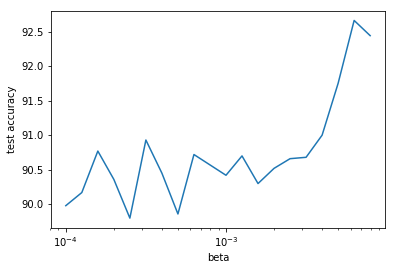

In [19]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []

for beta in regul_val: 
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()      
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,tf_regularisation_beta: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))
    
plt.semilogx(regul_val, accuracy_vals)          
plt.xlabel('beta')
plt.ylabel('test accuracy')        

Choice of best hyperparameter for regularization

In [21]:
winner_beta = regul_val[accuracy_vals.index(max(accuracy_vals))]
print(winner_beta)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_regularisation_beta: winner_beta}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

0.006309573444801955
Minibatch loss at step 0: 2315.351807
Minibatch accuracy: 12.5%
Validation accuracy: 29.0%
Minibatch loss at step 500: 1056.036377
Minibatch accuracy: 78.9%
Validation accuracy: 80.9%
Minibatch loss at step 1000: 559.895264
Minibatch accuracy: 82.0%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 296.578766
Minibatch accuracy: 83.6%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 157.124664
Minibatch accuracy: 88.3%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 83.660446
Minibatch accuracy: 86.7%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 44.760094
Minibatch accuracy: 85.9%
Validation accuracy: 86.5%
Test accuracy: 92.6%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

(200000, 784)


Text(0,0.5,'test accuracy')

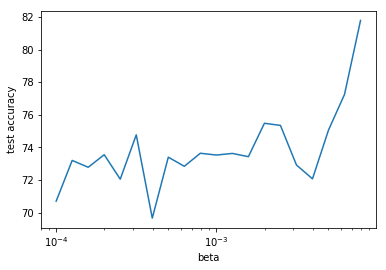

In [28]:
batch_size = 128
hidden_layer_size = 1024

def onelayer_NN(input, weights, biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_regularisation_beta = tf.placeholder(tf.float32)

  # Variables.
  weights = {
      'h1': tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size])),
      'out': tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  }
  biases = {
      'b1': tf.Variable(tf.zeros([hidden_layer_size])),
      'out': tf.Variable(tf.zeros([num_labels]))
  }

  # Training computation.
  logits = onelayer_NN(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))+ \
        tf_regularisation_beta*tf.nn.l2_loss(weights['h1']) + tf_regularisation_beta*tf.nn.l2_loss(weights['out'])

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(onelayer_NN(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(onelayer_NN(tf_test_dataset, weights, biases))
    

# Reduce dataset
print(train_dataset.shape)
train_dataset_small = train_dataset[:300,:]
train_labels_small = train_labels[:300,:]

num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []

for beta in regul_val: 
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()      
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_small.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_small[offset:(offset + batch_size), :]
        batch_labels = train_labels_small[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,tf_regularisation_beta: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))
    
plt.semilogx(regul_val, accuracy_vals)          
plt.xlabel('beta')
plt.ylabel('test accuracy')  

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

(200000, 784)


Text(0,0.5,'test accuracy')

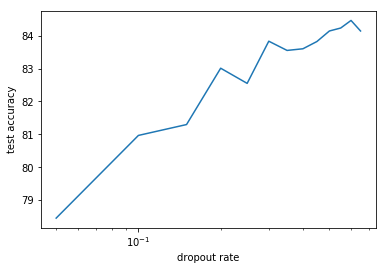

In [42]:
batch_size = 128
hidden_layer_size = 1024

def onelayer_NN(input, weights, biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

def onelayer_NN_with_dropout(input, weights, biases, dropout_rate):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    layer_1 = tf.nn.dropout(layer_1, keep_prob = 1 - dropout_rate)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_regularisation_beta = tf.placeholder(tf.float32)
  tf_dropout_rate = tf.placeholder(tf.float32)

  # Variables.
  weights = {
      'h1': tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size])),
      'out': tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  }
  biases = {
      'b1': tf.Variable(tf.zeros([hidden_layer_size])),
      'out': tf.Variable(tf.zeros([num_labels]))
  }

  # Training computation.
  logits = onelayer_NN_with_dropout(tf_train_dataset, weights, biases,tf_dropout_rate)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))+ \
        tf_regularisation_beta*tf.nn.l2_loss(weights['h1']) + tf_regularisation_beta*tf.nn.l2_loss(weights['out'])

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(onelayer_NN(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(onelayer_NN(tf_test_dataset, weights, biases))
    

# Reduce dataset
print(train_dataset.shape)
train_dataset_small = train_dataset[:300,:]
train_labels_small = train_labels[:300,:]

num_steps = 3001
dropout_rate_val = np.arange(0.05, 0.7, 0.05)
accuracy_vals = []
beta = 1e-3

for dropout_rate in dropout_rate_val: 
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()      
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_small.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_small[offset:(offset + batch_size), :]
        batch_labels = train_labels_small[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                     tf_regularisation_beta: beta, tf_dropout_rate: dropout_rate}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))
    
plt.semilogx(dropout_rate_val, accuracy_vals)          
plt.xlabel('dropout rate')
plt.ylabel('test accuracy') 

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


### Single-layer network: learning rate decay, regularization and dropout

In [53]:
batch_size = 128
hidden_layer_size = 1024

def onelayer_NN(input, weights, biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

def onelayer_NN_with_dropout(input, weights, biases, dropout_rate):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    layer_1 = tf.nn.dropout(layer_1, keep_prob = 1 - dropout_rate)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_starting_learning_rate = tf.placeholder(tf.float32)
  tf_decay_rate = tf.placeholder(tf.float32)
  tf_decay_step = tf.placeholder(tf.float32)
  tf_regularisation_beta = tf.placeholder(tf.float32)
  tf_dropout_rate = tf.placeholder(tf.float32)
  tf_stddev = tf.placeholder_with_default(1.0, shape=())
  
    
  # Variables.
  weights = {
      'h1': tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size], mean=0, stddev=tf_stddev)),
      'out': tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels], mean=0, stddev=tf_stddev))
  }
  biases = {
      'b1': tf.Variable(tf.zeros([hidden_layer_size])),
      'out': tf.Variable(tf.zeros([num_labels]))
  }

  # Training computation.
  logits = onelayer_NN_with_dropout(tf_train_dataset, weights, biases, tf_dropout_rate)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))+ \
        tf_regularisation_beta*tf.nn.l2_loss(weights['h1']) + tf_regularisation_beta*tf.nn.l2_loss(weights['out'])

  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(tf_starting_learning_rate, global_step, tf_decay_step, tf_decay_rate)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.0).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(onelayer_NN(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(onelayer_NN(tf_test_dataset, weights, biases))  

Initialized
Minibatch loss at step 0: 384.636719
Minibatch accuracy: 8.6%
Validation accuracy: 34.4%
Minibatch loss at step 500: 12.587808
Minibatch accuracy: 77.3%
Validation accuracy: 81.5%
Minibatch loss at step 1000: 11.922634
Minibatch accuracy: 82.8%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 5.623528
Minibatch accuracy: 82.8%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 9.108460
Minibatch accuracy: 83.6%
Validation accuracy: 80.4%
Minibatch loss at step 2500: 3.254185
Minibatch accuracy: 80.5%
Validation accuracy: 82.4%
Minibatch loss at step 3000: 3.016331
Minibatch accuracy: 79.7%
Validation accuracy: 82.5%
Minibatch loss at step 3500: 1.817564
Minibatch accuracy: 83.6%
Validation accuracy: 83.6%
Minibatch loss at step 4000: 1.719782
Minibatch accuracy: 87.5%
Validation accuracy: 83.4%
Minibatch loss at step 4500: 2.750089
Minibatch accuracy: 85.9%
Validation accuracy: 82.9%
Minibatch loss at step 5000: 1.327204
Minibatch accuracy: 82.8%
Validation accu

Text(0,0.5,'Accuracy')

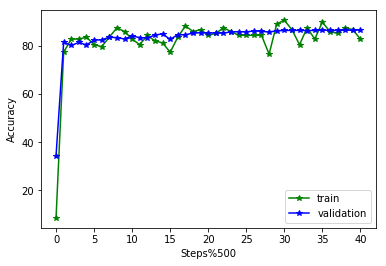

In [54]:
num_steps = 20001
starting_learning_rate = 0.5
learning_decay_step = 1000 # increasing decay_steps makes the exp decay less steep
learning_decay_rate = 0.8 # increasing decay_rate makes the exp decay less steep
beta = 0.0
dropout_rate = 0.2
stddev = 0.1

train_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                 tf_decay_step: learning_decay_step, tf_decay_rate: learning_decay_rate,
                 tf_regularisation_beta: beta, tf_dropout_rate: dropout_rate,
                 tf_starting_learning_rate: starting_learning_rate, tf_stddev: stddev}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      #print("offset ",offset)
      train_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy[-1])
      print("Validation accuracy: %.1f%%" % validation_accuracy[-1])
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
                            
plt.plot(train_accuracy, 'g-*', label='train')
plt.plot(validation_accuracy, 'b-*', label='validation')
plt.legend()
plt.xlabel('Steps%500')
plt.ylabel('Accuracy')

I learnt that:
- weights initialization (in our case the std dev of the normal distribution) makes a big impact on the performance. Good link for explanation https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/
- the best accuracy of 95.4% on the test dataset is achieved with:
    - stddev = 0.1
    - starting learning rate = 0.5, decay rate = 0.8, decay steps = 1000
    - drop out probability = 0.2
    - num_steps = 20001
    - no L2 regularization (L2 regularization reduces somehow the performance)
- the batch size matters
- the best accuracy is achieved after 20000 steps, however for this single-layer network there is clear overfitting already after 500 steps (early termination to prevent overfitting?)
- the network seems to achieve overfitting pretty early, suggesting that the learning rate whould be lowered. However, with a lower learning rate the performance did not improve and the overfitting did not occur after a larger number of iterations.

### Multiple layers with dropout and regularization

In [49]:
batch_size = 128
hidden_layer_size = 1024

def twolayer_NN(input, weights, biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

def twolayer_NN_with_dropout(input, weights, biases, dropout_rate):
    layer_1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(input, weights['h1']), biases['b1'])) , keep_prob = 1 - dropout_rate)
    layer_2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) , keep_prob = 1 - dropout_rate)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_starting_learning_rate = tf.placeholder(tf.float32)
  tf_decay_rate = tf.placeholder(tf.float32)
  tf_decay_step = tf.placeholder(tf.float32)
  tf_regularisation_beta = tf.placeholder(tf.float32)
  tf_dropout_rate = tf.placeholder(tf.float32)
  tf_stddev = tf.placeholder_with_default(1.0, shape=())
    
  # Variables.
  weights = {
      'h1': tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size], mean=0, stddev=tf_stddev)),
      'h2': tf.Variable(tf.truncated_normal([hidden_layer_size, hidden_layer_size], mean=0, stddev=tf_stddev)),
      'out': tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels], mean=0, stddev=tf_stddev))
  }
  biases = {
      'b1': tf.Variable(tf.zeros([hidden_layer_size])),
      'b2': tf.Variable(tf.zeros([hidden_layer_size])),
      'out': tf.Variable(tf.zeros([num_labels]))
  }

  # Training computation.
  logits = twolayer_NN_with_dropout(tf_train_dataset, weights, biases, tf_dropout_rate)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))+ \
        tf_regularisation_beta*tf.nn.l2_loss(weights['h1']) + \
        tf_regularisation_beta*tf.nn.l2_loss(weights['h2']) + tf_regularisation_beta*tf.nn.l2_loss(weights['out'])

  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(tf_starting_learning_rate, global_step, tf_decay_step, tf_decay_rate)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(twolayer_NN(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(twolayer_NN(tf_test_dataset, weights, biases)) 

Initialized
Minibatch loss at step 0: 14993.609375
Minibatch accuracy: 6.2%
Validation accuracy: 16.8%
Minibatch loss at step 500: 4683.961426
Minibatch accuracy: 42.2%
Validation accuracy: 74.0%
Minibatch loss at step 1000: 3956.060059
Minibatch accuracy: 57.8%
Validation accuracy: 76.9%
Minibatch loss at step 1500: 3879.535889
Minibatch accuracy: 61.7%
Validation accuracy: 77.8%
Minibatch loss at step 2000: 3641.784424
Minibatch accuracy: 62.5%
Validation accuracy: 78.5%
Minibatch loss at step 2500: 3497.960693
Minibatch accuracy: 61.7%
Validation accuracy: 78.8%
Minibatch loss at step 3000: 3234.732666
Minibatch accuracy: 65.6%
Validation accuracy: 78.9%
Minibatch loss at step 3500: 3161.121338
Minibatch accuracy: 63.3%
Validation accuracy: 79.0%
Minibatch loss at step 4000: 3400.161865
Minibatch accuracy: 64.8%
Validation accuracy: 79.1%
Minibatch loss at step 4500: 3101.140137
Minibatch accuracy: 68.8%
Validation accuracy: 79.2%
Minibatch loss at step 5000: 3270.833008
Minibatch a

Text(0,0.5,'Accuracy')

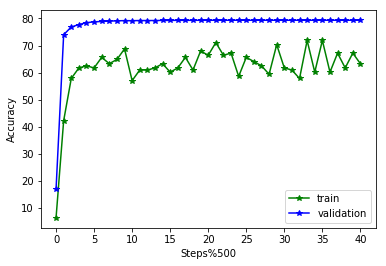

In [52]:
num_steps = 20001
starting_learning_rate = 0.0001
learning_decay_step = 1000 # increasing decay_steps makes the exp decay less steep
learning_decay_rate = 0.6 # increasing decay_rate makes the exp decay less steep
beta = 0.001
dropout_rate = 0.5
stddev = 0.5

train_accuracy = []
validation_accuracy = []


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                 tf_decay_step: learning_decay_step, tf_decay_rate: learning_decay_rate,
                 tf_regularisation_beta: beta, tf_dropout_rate: dropout_rate,
                 tf_starting_learning_rate: starting_learning_rate, tf_stddev: stddev}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy[-1])
      print("Validation accuracy: %.1f%%" % validation_accuracy[-1])
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
                            
plt.plot(train_accuracy, 'g-*', label='train')
plt.plot(validation_accuracy, 'b-*', label='validation')
plt.legend()
plt.xlabel('Steps%500')
plt.ylabel('Accuracy')

Sensitivity analysis for dropout rate, regularization values, learning rate decay values

In [19]:
num_steps = 3001
dropout_rate_val = np.arange(0.1, 0.6, 0.1)
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.5)]
accuracy_vals = np.zeros((len(regul_val), len(dropout_rate_val)))
    
for i,dropout_rate in enumerate(dropout_rate_val):
    print('>> Dropout_rate =', dropout_rate)
    for j,regul in enumerate(regul_val):
        print('>> Regularization param =', regul)
        with tf.Session(graph=graph) as session:
          tf.global_variables_initializer().run()      
          for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                         tf_regularisation_beta: regul, tf_dropout_rate: dropout_rate}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
          accuracy_vals[j,i] = accuracy(test_prediction.eval(), test_labels)


X, Y = np.meshgrid(dropout_rate_val, regul_val)
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot_wireframe(X, Y, accuracy_vals, color='black')
ax.contour(X, Y, accuracy_vals, 50, cmap='binary')
ax.contour3D(X, Y, accuracy_vals, 50, cmap='binary')
ax.set_title('wireframe')

>> Dropout_rate = 0.1
>> Regularization param = 0.0001
>> Regularization param = 0.00031622776601683794
>> Regularization param = 0.001
>> Regularization param = 0.0031622776601683794
>> Dropout_rate = 0.2
>> Regularization param = 0.0001
>> Regularization param = 0.00031622776601683794
>> Regularization param = 0.001
>> Regularization param = 0.0031622776601683794
>> Dropout_rate = 0.30000000000000004
>> Regularization param = 0.0001
>> Regularization param = 0.00031622776601683794
>> Regularization param = 0.001
>> Regularization param = 0.0031622776601683794
>> Dropout_rate = 0.4
>> Regularization param = 0.0001
>> Regularization param = 0.00031622776601683794
>> Regularization param = 0.001
>> Regularization param = 0.0031622776601683794
>> Dropout_rate = 0.5
>> Regularization param = 0.0001
>> Regularization param = 0.00031622776601683794
>> Regularization param = 0.001
>> Regularization param = 0.0031622776601683794


ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>